In [1]:
# plot feature importance manually
import numpy as np
import pandas as pd
from pandas import DataFrame
from xgboost import XGBClassifier
from matplotlib import pyplot

# Sliding window - stimulation

In [3]:
import xgboost
from matplotlib import pyplot
from xgboost import XGBRegressor
# define model
model = XGBRegressor()

## Caculate pre_errors in predictors

In [9]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror',
							 colsample_bytree = 0.5,
							 learning_rate = 0.1,
							 max_depth = 3,
							 min_child_weight = 3,
							 n_estimators = 1000,
							 subsample = 0.7)
	#model = XGBRegressor(objective= 'reg:linear', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_percentage_error(test[:, -1], predictions)
	return error, test[:, -1], predictions


## The MAPE comparation

In [35]:
#reset
df = pd.read_csv('../Code/Data/mf_UU_0607.csv',header=0, index_col=0)
df = df.iloc[6:,]
df

,BA_math,BA_Informatica,BA_Physics_Astronomy,BA_AI,BA_NL,BA_EER,BA_INTER,BtoM,MA_NL,MA_EER,MA_INTER,Total_MA
Year,,,,,,,,,,,,
2010,35,33,34,11,469,3,3,111,16,12,1,29
2011,48,38,38,14,520,5,2,114,21,18,4,43
2012,75,49,65,24,642,8,2,179,19,11,1,31
2013,69,73,62,11,643,6,3,165,26,13,2,41
2014,61,81,55,13,684,4,1,170,28,6,1,35
2015,88,103,82,21,919,3,7,225,33,9,4,46
2016,53,89,61,33,889,9,5,183,48,9,4,61
2017,80,111,65,30,961,11,3,229,33,11,6,50
2018,80,117,70,45,1020,14,6,248,56,12,10,78


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 2010 to 2024
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BA_Math               15 non-null     float64
 1   BA_Informatica        15 non-null     float64
 2   BA_Physics_Astronomy  15 non-null     float64
 3   BA_AI                 15 non-null     float64
 4   BA_NL                 15 non-null     float64
 5   BA_EEA                15 non-null     float64
 6   BA_others             15 non-null     float64
 7   BAtoMA                15 non-null     float64
 8   MA_CS                 15 non-null     float64
dtypes: float64(9)
memory usage: 1.2 KB


In [36]:
def caculate_mse(df, n_in):
	errors = []
	table = {}
	for x in df.columns:
		series = df[[x]]
		values = series.values
		# transform the time series data into supervised learning
		data = series_to_supervised(values, n_in) #Number of lag observations as input (X)
		# evaluate
		mae, y, yhat = walk_forward_validation(data,2) # validation set
		table['Method'] = 'XGB_lag{}'.format(n_in)
		table[x] = mae
		# plot expected vs preducted
	errors.append(table)
	return(errors)


In [37]:
#walk_forward_validation(data,2)
err = []
for i in range(3,6):
	mse = pd.DataFrame(caculate_mse(df, i))
	err.append(mse)
pred_mse2 = pd.concat(err, ignore_index=True)
pred_mse2

>expected=80.0, predicted=70.6
>expected=71.0, predicted=69.1
>expected=117.0, predicted=92.7
>expected=95.0, predicted=105.5
>expected=70.0, predicted=65.0
>expected=90.0, predicted=71.6
>expected=45.0, predicted=22.4
>expected=72.0, predicted=30.7
>expected=1020.0, predicted=830.7
>expected=1046.0, predicted=952.2
>expected=14.0, predicted=6.9
>expected=6.0, predicted=7.7
>expected=6.0, predicted=3.8
>expected=4.0, predicted=6.2
>expected=248.0, predicted=196.7
>expected=234.0, predicted=238.9
>expected=56.0, predicted=33.9
>expected=57.0, predicted=45.5
>expected=12.0, predicted=9.7
>expected=6.0, predicted=10.8
>expected=10.0, predicted=3.6
>expected=7.0, predicted=7.4
>expected=78.0, predicted=47.2
>expected=70.0, predicted=67.3
>expected=80.0, predicted=69.6
>expected=71.0, predicted=72.9
>expected=117.0, predicted=95.5
>expected=95.0, predicted=101.4
>expected=70.0, predicted=65.1
>expected=90.0, predicted=66.7
>expected=45.0, predicted=24.4
>expected=72.0, predicted=29.6
>expec

,Method,BA_math,BA_Informatica,BA_Physics_Astronomy,BA_AI,BA_NL,BA_EER,BA_INTER,BtoM,MA_NL,MA_EER,MA_INTER,Total_MA
0,XGB_lag3,0.071992,0.159047,0.137890,0.538266,0.137666,0.390676,0.452901,0.113893,0.298484,0.492991,0.352327,0.217043
1,XGB_lag4,0.078154,0.125712,0.164463,0.524145,0.146429,0.476966,0.232281,0.139613,0.325088,0.436722,0.432509,0.294736
2,XGB_lag5,0.075217,0.123592,0.117052,0.466324,0.094095,0.493757,0.237909,0.096677,0.291705,0.453883,0.336257,0.247582


In [28]:
#walk_forward_validation(data,3)
err = []
for i in range(3,6):
	mse = pd.DataFrame(caculate_mse(df, i))
	err.append(mse)
pred_mse3 = pd.concat(err, ignore_index=True)
pred_mse3

>expected=82.0, predicted=72.4
>expected=82.0, predicted=74.1
>expected=72.0, predicted=71.0
>expected=120.0, predicted=94.2
>expected=120.0, predicted=100.6
>expected=103.0, predicted=111.7
>expected=65.0, predicted=66.8
>expected=71.0, predicted=66.0
>expected=90.0, predicted=72.6
>expected=33.0, predicted=20.3
>expected=47.0, predicted=23.7
>expected=78.0, predicted=32.4
>expected=961.0, predicted=787.0
>expected=1020.0, predicted=830.7
>expected=1046.0, predicted=952.2
>expected=11.0, predicted=5.5
>expected=14.0, predicted=6.9
>expected=6.0, predicted=7.7
>expected=3.0, predicted=4.1
>expected=6.0, predicted=3.8
>expected=4.0, predicted=6.2
>expected=229.0, predicted=186.6
>expected=248.0, predicted=196.7
>expected=234.0, predicted=238.9
>expected=33.0, predicted=33.8
>expected=56.0, predicted=33.9
>expected=57.0, predicted=45.5
>expected=11.0, predicted=9.4
>expected=12.0, predicted=9.7
>expected=6.0, predicted=10.8
>expected=6.0, predicted=2.8
>expected=10.0, predicted=3.6
>expe

,Method,BA_math,BA_Informatica,BA_Physics_Astronomy,BA_AI,BA_NL,BA_EER,BA_INTER,BtoM,MA_NL,MA_EER,MA_INTER,Total_MA
0,XGB_lag3,0.075701,0.153945,0.097243,0.488084,0.152125,0.427176,0.426254,0.137625,0.206921,0.377922,0.412215,0.171577
1,XGB_lag4,0.093689,0.120829,0.117582,0.453649,0.142827,0.489695,0.303001,0.145962,0.250395,0.382057,0.455006,0.214269
2,XGB_lag5,0.383580,0.392652,0.407609,0.643284,0.395890,0.647353,0.436383,0.397057,0.522753,0.620771,0.529727,0.495055


In [31]:
pd.concat([pred_mse2,pred_mse3])
# use the prediction of lag4

,Method,BA_math,BA_Informatica,BA_Physics_Astronomy,BA_AI,BA_NL,BA_EER,BA_INTER,BtoM,MA_NL,MA_EER,MA_INTER,Total_MA
0,XGB_lag3,0.054844,0.123352,0.132380,0.540275,0.137666,0.390676,0.452901,0.113893,0.298484,0.492991,0.352327,0.217043
1,XGB_lag4,0.081590,0.093744,0.158425,0.528958,0.146429,0.476966,0.232281,0.139613,0.325088,0.436722,0.432509,0.294736
2,XGB_lag5,0.078419,0.091061,0.115260,0.472502,0.094095,0.493757,0.237909,0.096677,0.291705,0.453883,0.336257,0.247582
0,XGB_lag3,0.075701,0.153945,0.097243,0.488084,0.152125,0.427176,0.426254,0.137625,0.206921,0.377922,0.412215,0.171577
1,XGB_lag4,0.093689,0.120829,0.117582,0.453649,0.142827,0.489695,0.303001,0.145962,0.250395,0.382057,0.455006,0.214269
2,XGB_lag5,0.383580,0.392652,0.407609,0.643284,0.395890,0.647353,0.436383,0.397057,0.522753,0.620771,0.529727,0.495055


## Predict 2020-2024

In [16]:
# finalize model and make a prediction for monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor


In [17]:
def predect_new_data(df, pred_year, lagx):
	pred_new = []
	table = {}
	for x in df.columns:
		series = df[[x]]
		values = series.values
		train = series_to_supervised(values, n_in=lagx)
		# split into input and output columns
		trainX, trainy = train[:, :-1], train[:, -1]
		# fit model
		model = XGBRegressor(objective='reg:squarederror',
							 colsample_bytree = 0.5,
							 learning_rate = 0.1,
							 max_depth = 3,
							 min_child_weight = 3,
							 n_estimators = 1000,
							 subsample = 0.7)

		model.fit(trainX, trainy)
		# construct an input for a new preduction
		row = values[-lagx:].flatten()
		#row = np.append(row, 2020)
		# make a one-step prediction
		yhat = model.predict(asarray([row]))
		# plot expected vs preducted
		table[x] = yhat[0]
	pred_new.append(table)
	pred_x = pd.DataFrame(pred_new, index=[pred_year])

	return(pred_x)

In [74]:
#df = pd.read_csv('../Code/meta_ver5_11to20.csv',header=0, index_col=0)
# prediction from 2020 to 2025
df = pd.read_csv('../Code/Data/VSNU_UU.csv',header=0, index_col=0)
#df = pd.read_csv('../Code/Data/mf_UU_0607.csv',header=0, index_col=0)
df = df.iloc[6:,]
for i in range(2020,2025):
	lag3 = predect_new_data(df,i,3)[['BA_Math','BA_EEA','MA_CS']]
	lag4 = predect_new_data(df,i,4)[['BA_others','BA_Informatica','BAtoMA','BA_Physics_Astronomy']]
	lag5 = predect_new_data(df,i,5)[['BA_AI','BA_NL']]

	dfnew = pd.concat([lag3,lag4,lag5],join='outer', axis=1)
# add prediction to df
	df = df.append(dfnew)
df

,BA_Math,BA_Informatica,BA_Physics_Astronomy,BA_AI,BA_NL,BA_EEA,BA_others,BAtoMA,MA_CS
2010,37.000000,34.000000,37.000000,11.000000,469.000000,3.000000,3.000000,111.000000,29.000000
2011,50.000000,41.000000,38.000000,14.000000,520.000000,5.000000,2.000000,114.000000,43.000000
2012,76.000000,52.000000,65.000000,26.000000,642.000000,8.000000,2.000000,179.000000,31.000000
2013,70.000000,79.000000,63.000000,12.000000,643.000000,6.000000,3.000000,165.000000,41.000000
2014,64.000000,91.000000,57.000000,14.000000,684.000000,4.000000,1.000000,170.000000,35.000000
2015,96.000000,110.000000,83.000000,22.000000,919.000000,3.000000,7.000000,225.000000,46.000000
2016,57.000000,96.000000,62.000000,33.000000,889.000000,9.000000,5.000000,183.000000,61.000000
2017,82.000000,120.000000,65.000000,33.000000,961.000000,11.000000,3.000000,229.000000,50.000000
2018,82.000000,120.000000,71.000000,47.000000,1020.000000,14.000000,6.000000,248.000000,78.000000
2019,72.000000,103.000000,90.000000,78.000000,1046.000000,6.000000,4.000000,234.000000,70.000000


In [76]:
df.to_csv('Data/VSNU_simulation_UU.csv',index=True)

"""
	lag3 = predect_new_data(df,i,3)[['BA_math','BA_EER','Total_MA']]
	lag4 = predect_new_data(df,i,4)[['BA_INTER','BA_Informatica','BA_Physics_Astronomy','BA_AI','BA_NL','BtoM']]
	lag5 = predect_new_data(df,i,5)[[]]
"""

"\n\tlag3 = predect_new_data(df,i,3)[['BA_math','BA_EER','Total_MA']]\n\tlag4 = predect_new_data(df,i,4)[['BA_INTER','BA_Informatica','BA_Physics_Astronomy','BA_AI','BA_NL','BtoM']]\n\tlag5 = predect_new_data(df,i,5)[[]]\n"

In [23]:
#XGBoost hyper-parameter tuning
from sklearn.model_selection import GridSearchCV
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

hyperParameterTuning(trainX, trainy)
"""
%time xgb_model.fit(trainX, trainy, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb_model.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print("MAE: ", mae_xgb)
"""

NameError: name 'X_train' is not defined

In [113]:
# his + 2020-2025
df.to_csv('simulation_data_2025_0602.csv',index=True)

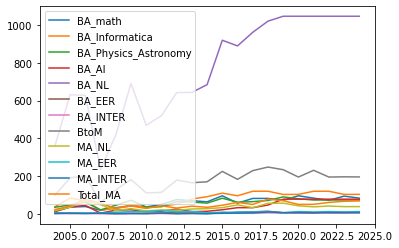

In [21]:
import matplotlib.pyplot as plt
plt.plot(df)
plt.legend(df.columns)

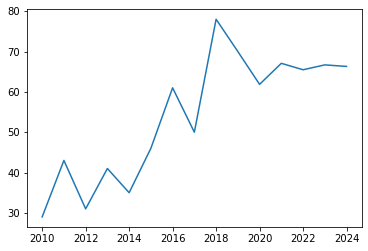

In [21]:
import matplotlib.pyplot as plt
plt.plot(df['Total_MA'])


In [348]:
dfnew_25 = pd.read_csv('../Code/simulation_data_2025.csv')
dfnew_25

,Unnamed: 0,BA_INCA,BA_INKU,BA_NAST,BA_WISK,BAtoMA_perc,UU_perc,MA_EER,MA_Inter,Inter_Master,Total_MA
0,2011,62.000000,45.000000,59.000000,70.000000,0.821124,0.571429,0.035429,0.007238,13.890000,35.000000
1,2012,59.000000,35.000000,79.000000,76.000000,0.810662,0.566667,0.039643,0.009643,14.700000,30.000000
2,2013,92.000000,32.000000,76.000000,69.000000,0.821818,0.707317,0.054746,0.013153,15.890000,41.000000
3,2014,107.000000,37.000000,69.000000,60.000000,0.796296,0.722222,0.036728,0.009877,16.990000,54.000000
4,2015,110.000000,49.000000,83.000000,85.000000,0.843558,0.615385,0.041489,0.013564,19.440000,39.000000
5,2016,96.000000,77.000000,62.000000,48.000000,0.871545,0.650000,0.044972,0.014401,22.010000,40.000000
6,2017,120.000000,101.000000,65.000000,71.000000,0.910405,0.575000,0.050863,0.014039,23.960000,40.000000
7,2018,120.000000,116.000000,71.000000,72.000000,0.901682,0.690476,0.062872,0.017428,25.790000,84.000000
8,2019,103.000000,97.000000,90.000000,63.000000,0.897681,0.703125,0.077401,0.024007,27.350000,64.000000
9,2020,119.999466,97.000519,63.476044,70.648193,0.898172,0.640803,0.076598,0.023352,27.348902,58.263607
